In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import matthews_corrcoef
from math import sqrt

In [2]:
train = pd.read_csv('D:/_Citi Hackathon/Dataset/Train.csv', index_col=[0])
test = pd.read_csv('D:/_Citi Hackathon/Dataset/Test_fin.csv', index_col=0)

C:\Users\nithy\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
def date_formatting(data):
    '''
    Converts date from str to datetime, adds DD column
    Input:
    -------
    data: raw test/train data
    ''' 
    data['transaction_val_dt'] = pd.to_datetime(data['transaction_val_dt'], format='%Y-%m-%d') 
    data['transaction_DD'] = data['transaction_val_dt'].apply(lambda x: int(x.day))
#     data['transaction_val_dt'] = data['transaction_val_dt'] - min(data['transaction_val_dt'])
    data.drop('yearmonth', axis=1, inplace=True)
    ## Q: should we remove duplicates and add a column or not?

In [4]:
def add_bene_features(data):
    '''
    Creates beneficiary related features
    Input:
    -------
    data: train/test data with DD column added  
    '''  
    bene = data.groupby('bene_act_no_dummy')

    plt.figure(figsize=(15,10))
    plt.hist(bene['payroll_ind'].count(), bins=50)
    plt.show()

    # number of industries bene is mapped to
    bene_ind_c = bene['rem_company_ind'].nunique()
    data['bene_ind_count'] = bene_ind_c[data.bene_act_no_dummy].values    

    # DD abs difference with mean DD
    bene_DD_mean = bene['transaction_DD'].mean()
    data['bene_DD_mean_diff'] = abs(bene_DD_mean[data.bene_act_no_dummy].values - data['transaction_DD'])
    
    # diff of mean txn_amount for bene
    bene_txn = bene['txn_amt'].mean()
    data['avg_bene_txn_diff'] = data['txn_amt'] - bene_txn[data.bene_act_no_dummy].values
    

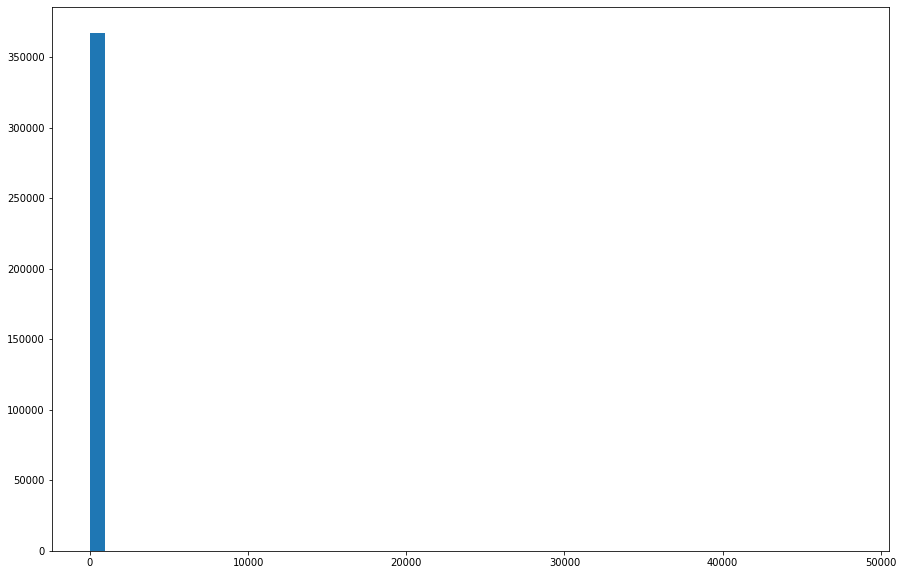

In [5]:
date_formatting(train)
add_bene_features(train)

In [6]:
train.head()

,rem_company_id_dummy,rem_act_no_dummy,bene_act_no_dummy,txn_amt,transaction_val_dt,txn_type,rem_company_ind,payroll_ind,transaction_DD,bene_ind_count,bene_DD_mean_diff,avg_bene_txn_diff
txn_refr_key_dummy,,,,,,,,,,,,
1,1000000000,5000000,8000000,1.458730,2020-09-17,CROSS BORDER,Consumer,0,17,1,5.666667,-0.021845
4,1000000020,5000200,8000200,1.269716,2020-09-30,CROSS BORDER,Communications,0,30,1,0.333333,0.000794
5,1000000030,5000300,8000300,1.190682,2020-09-22,CROSS BORDER,Industrials,0,22,1,0.000000,0.000000
7,1000000050,5000500,8000500,5.657271,2020-09-29,CROSS BORDER,Technology,0,29,1,10.857143,0.296643
8,1000000020,5000200,8000600,1.239628,2020-09-29,CROSS BORDER,Communications,0,29,1,0.200000,-0.011784


In [ ]:
np.unique(train.rem_company_ind)

## ignore beyond this 

In [9]:
bene = train.groupby('bene_act_no_dummy')
n_bene = len(np.unique(train['bene_act_no_dummy']))

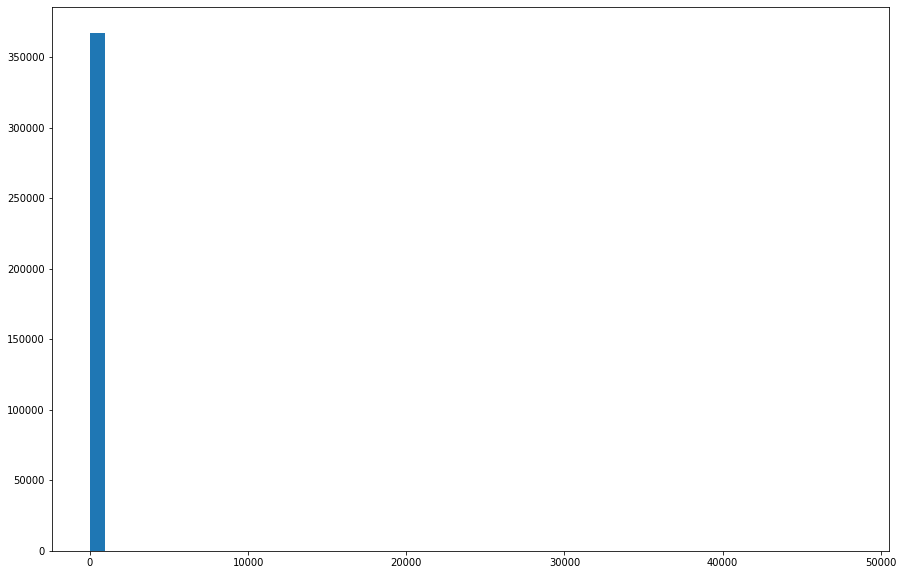

In [5]:
plt.figure(figsize=(15,10))
plt.hist(bene['payroll_ind'].count(), bins=50)
plt.show()

### industry map

In [6]:
# print(np.unique(bene['rem_company_ind'].nunique(), return_counts=True))
# 360984/n_bene
# multi_ind_bene = bene.filter(lambda x : x['rem_company_ind'].nunique()>1)
# multi_ind_bene.groupby('bene_act_no_dummy')['payroll_ind'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([360984,   6008,    243,     32,     15,      6,      4,      5,
             1,      1], dtype=int64))

In [8]:
bene_ind_c = bene['rem_company_ind'].nunique()
train['bene_ind_count'] = bene_ind_c[train.bene_act_no_dummy].values

### bene mode(date)-txn_date 

In [38]:
# bene_date
bene_DD_mean = bene['transaction_DD'].mean()
train['bene_DD_mode_diff'] = abs(bene_DD_mean[train.bene_act_no_dummy].values - train['transaction_DD']) 

In [36]:
(train[train['payroll_ind']==1]['transaction_DD']).describe()

count    121939.000000
mean         18.637720
std           6.695062
min           1.000000
25%          14.000000
50%          21.000000
75%          23.000000
max          31.000000
Name: transaction_DD, dtype: float64

In [37]:
(train[train['payroll_ind']==0]['transaction_DD']).describe()

count    1.308694e+06
mean     1.879849e+01
std      9.195570e+00
min      1.000000e+00
25%      1.100000e+01
50%      2.100000e+01
75%      2.900000e+01
max      3.100000e+01
Name: transaction_DD, dtype: float64

### Txn amount avg 

In [11]:
bene_txn = bene['txn_amt'].mean()
train['avg_bene_txn_diff'] = train['txn_amt'] - bene_txn[train.bene_act_no_dummy].values

### company map 

In [9]:
bene_comp_c = bene['rem_company_id_dummy'].nunique()
train['bene_comp_count'] = bene_comp_c[train.bene_act_no_dummy].values

# # # 

In [10]:
delta = (bene['transaction_val_dt'].max()-bene['transaction_val_dt'].min()).apply(lambda x: x.days)
avgTxnGap = delta/(bene.count()['payroll_ind']-1)

In [11]:
avgTxnGap

bene_act_no_dummy
8000000     58.5
8000200     30.5
8000300      NaN
8000500     24.5
8000600     30.5
            ... 
74587500     NaN
74587600     NaN
74587700     NaN
74587800     NaN
74587900     NaN
Length: 367299, dtype: float64

In [12]:
delta

bene_act_no_dummy
8000000     117
8000200      61
8000300       0
8000500     147
8000600     122
           ... 
74587500      0
74587600      0
74587700      0
74587800      0
74587900      0
Name: transaction_val_dt, Length: 367299, dtype: int64

In [22]:
pair_train = pd.read_csv('D:/_Citi Hackathon/Dataset/groupDF.csv', index_col=0)

In [26]:
pair_train['bene_act_no_dummy'] = pd.Series(pair_train.index).apply(lambda x:int(x.split(',')[1][:-1])).values

In [29]:
len(np.unique(pair_train.bene_act_no_dummy))/len(bene)

1.0